## Import Libraries & Load Dataset

In [2]:
import os
import time
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten, BatchNormalization, Dense, Dropout
from IPython import display
import matplotlib.pyplot as plt
import imageio

## Fashion Mnist Dataset

In [4]:
(images,labels),(_,_) = tf.keras.datasets.fashion_mnist.load_data()
images = (images - 127.5) / 127.5 ## ==> Normilize images to [-1,1]
images = images[...,tf.newaxis]

In [6]:
Train = tf.data.Dataset.from_tensor_slices(images).shuffle(60000).batch(256)

# Model
## Generator Model

In [7]:
generator_model = Sequential()
generator_model.add(Dense(7*7*256,activation="relu",input_dim=100))
generator_model.add(BatchNormalization())
generator_model.add(Reshape((7,7,256)))

generator_model.add(Conv2DTranspose(256,(5,5),strides=(2,2),padding="same",activation="relu"))
generator_model.add(BatchNormalization())

generator_model.add(Conv2DTranspose(128,(5,5),strides=(1,1),padding="same",activation="relu"))
generator_model.add(BatchNormalization())

generator_model.add(Conv2DTranspose(64,(5,5),strides=(1,1),padding="same",activation="relu"))
generator_model.add(BatchNormalization())

generator_model.add(Conv2DTranspose(1,(5,5),strides=(2,2),padding="same",activation="tanh"))

In [8]:
generator_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 256)       1638656   
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       5

## Discriminator Model

In [9]:
discriminator_model = Sequential()
discriminator_model.add(Conv2D(64,(5,5),strides=(2,2),activation="relu",padding="same",input_shape=(28,28,1)))
discriminator_model.add(Dropout(0.2))

discriminator_model.add(Conv2D(128,(5,5),strides=(2,2),activation="relu",padding="same"))
discriminator_model.add(Dropout(0.2))

discriminator_model.add(Conv2D(256,(5,5),strides=(2,2),activation="relu",padding="same"))
discriminator_model.add(Dropout(0.2))

discriminator_model.add(Flatten())
discriminator_model.add(Dense(1,activation="sigmoid"))

In [10]:
discriminator_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)             

In [11]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()
discriminator_loss = tf.keras.metrics.Mean()
seed = tf.random.normal([16,100])

In [12]:
def train_step(images):
    noise = tf.random.normal([256,100])
    with tf.GradientTape() as gTape_gen, tf.GradientTape() as gTape_disc:
        generated_images = generator_model(noise,training=True)
        real_images = discriminator_model(images,training=True)
        fake_images = discriminator_model(generated_images,training=True)
        
        loss_gen = loss_function(tf.ones_like(fake_images),fake_images)
        loss_real = loss_function(tf.ones_like(real_images),real_images)
        loss_fake = loss_function(tf.zeros_like(fake_images),fake_images)
        loss_disc = loss_real + loss_fake
        discriminator_loss(loss_disc)
        
    gradient_gen = gTape_gen.gradient(loss_gen,generator_model.trainable_variables)
    gradient_disc = gTape_disc.gradient(loss_disc,discriminator_model.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradient_gen,generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradient_disc,discriminator_model.trainable_variables))

In [13]:
def save_images(generator_model, epoch, seed):
  prediction = generator_model(seed, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(prediction.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(prediction[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig(f"image{epoch}.png")
  plt.show()

In [14]:
def train():
  for epoch in range(200):
    start = time.time()
    discriminator_loss.reset_states()
    
    for images in Train:
      train_step(images)
    display.clear_output(wait=True)
    save_images(generator_model,epoch + 1,seed)


    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    print ('Loss: {} '.format(discriminator_loss.result()))

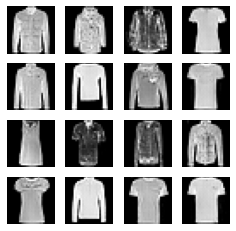

Time for epoch 200 is 32.56295418739319 sec
Loss: 0.3617967963218689 


In [15]:
train()

In [16]:
with imageio.get_writer("FashionMnist.gif", mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)